# (수업) 시계열 자료분석 실습 5

> AR, MA, ARMA
- toc:true
- branch: master
- badges: true
- comments: true
- author: 조윤호

In [66]:
library('tidyverse')
library('gridExtra')
library('forecast')

## AR

### function으로 만든 AR(1)

- 함수로 생성하기

- n개 보다 100개 더 생성하는 이유 : 초기값을 만들고 업데이트할 때 초기값의 영향을 줄여주기 위해 앞에 100개 없애기 위해서<br>
쌩으로 n개만 쓰면 초기값 영향 많이 받음.

In [67]:
sim_ar1 <- function(n, phi, mu, sigma){
    z <- rep(mu, n + 100)
    for(k in 2 : (n + 100)){
        z[k] <- mu + phi*(z[k-1] - mu) + rnorm(1, 0, sigma)
        }
    return(z[-(1:100)])
    }

`-` 전체중에서 앞에꺼 100개 떼고 생성

- 정상시계열이 되기 위해서는 $\phi$가 1보다 작기만 하면 됨.<br>
평균은 그냥 간단하게 0으로 함.

In [68]:
n <- 100
phi <- -0.5
mu <- 0
sigma <- 1

In [69]:
tmp.data <- data.frame(
    t = 1:n,
    z = sim_ar1(n, phi, mu, sigma)
    )

In [70]:
p1 <- ggplot(tmp.data, aes(t, z)) +
geom_line(col = 'steelblue', lwd = 1.2) +
geom_hline(yintercept = 0, lty = 2, col = 'grey') +
ggtitle(paste0("Time series plot : AR(1) - phi = ", phi)) +
theme_bw() +
theme(axis.title.y = element_blank())

p2 <- ggAcf(tmp.data$z, lwd = 1.5) +
theme_bw() + ylim(-1, 1) + 
ggtitle("SACF") +
theme(axis.title.y = element_blank())

p3 <- ggPacf(tmp.data$z, lwd = 1.5) +
theme_bw() + ylim(-1, 1) +
ggtitle('SPACF') +
theme(axis.title.y = element_blank())

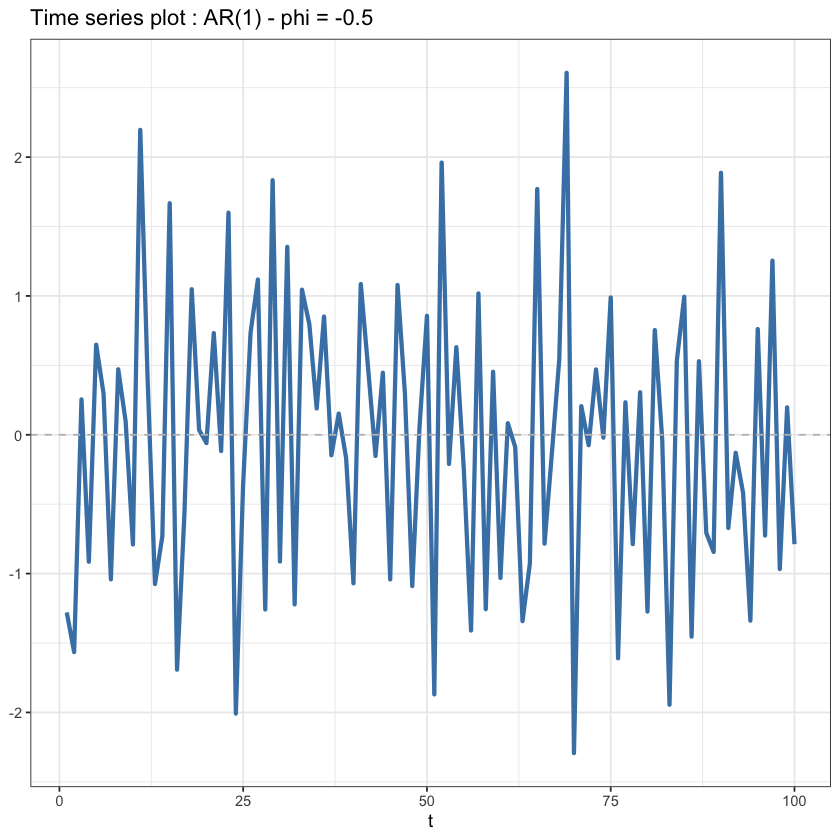

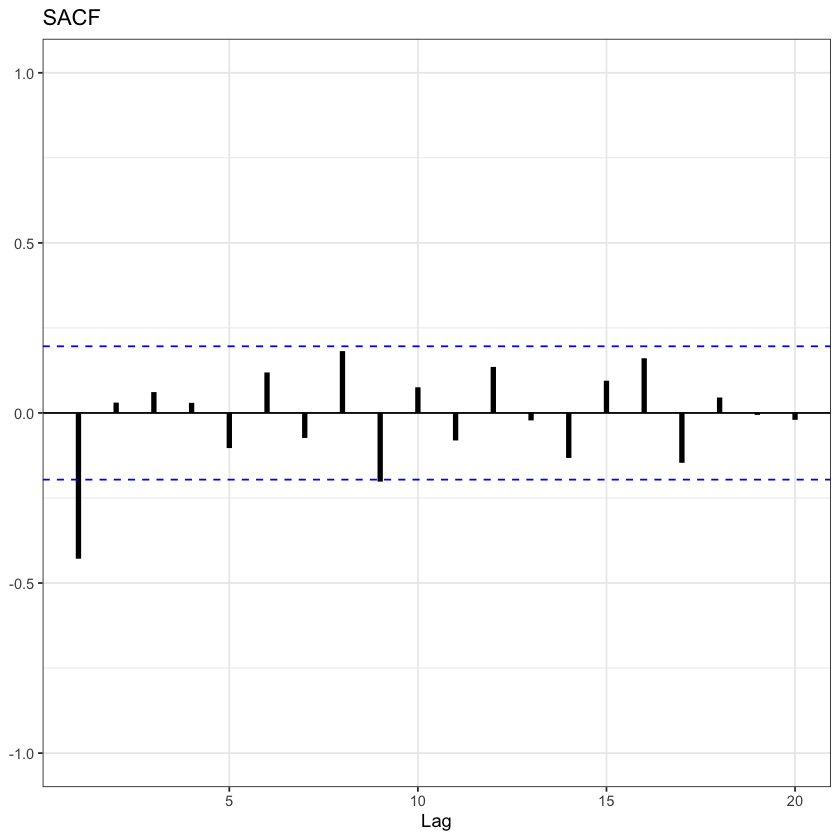

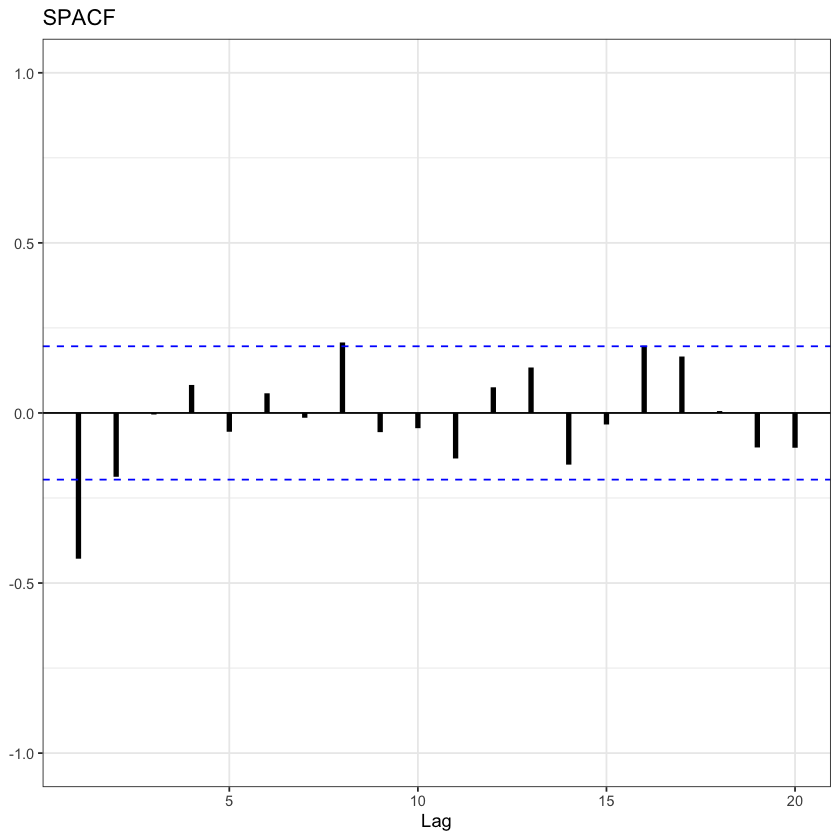

In [71]:
p1
p2
p3

- 해석 : 0을 기준으로 대칭적으로 움직임(정상 시계열: 추세도 없고 계절도 없어보임), AR(1)은 pacf를 봐야하는데 첫 번째와 두 번째가 유의하게 나옴.<br>
근데 원래 알기로는 첫 번째만 유의하고 두 번째부터 유의하지 않아야하는데 이거는 100개의 sampling이라 약간의 오차<br>
표본을 10000개씩 뽑아보면 이론에 근접하게 나옴.

### function으로 만든 AR(p)

$Z_t = \delta + \phi_1*Z_{t-1} + ... + \phi_p * Z_{t-p} + \epsilon_t$

In [72]:
sim_ar <- function(n, mu, phi, sigma){
    p <- length(phi) # 차수
    z <- rep(mu, (100 + n))
    delta <- (1-sum(phi))*mu 
    
    for(k in (length(phi) + 1) : (n + 100)){
        
        z[k] <- delta + sum(z[(k-1):(k-p)]*phi) + rnorm(1, 0, sigma)
        }
    return(z[-(1:100)])
    }

`-` 예를들어 AR(1)면

In [73]:
z <- sim_ar(100, 0, phi = c(0.5), 1)

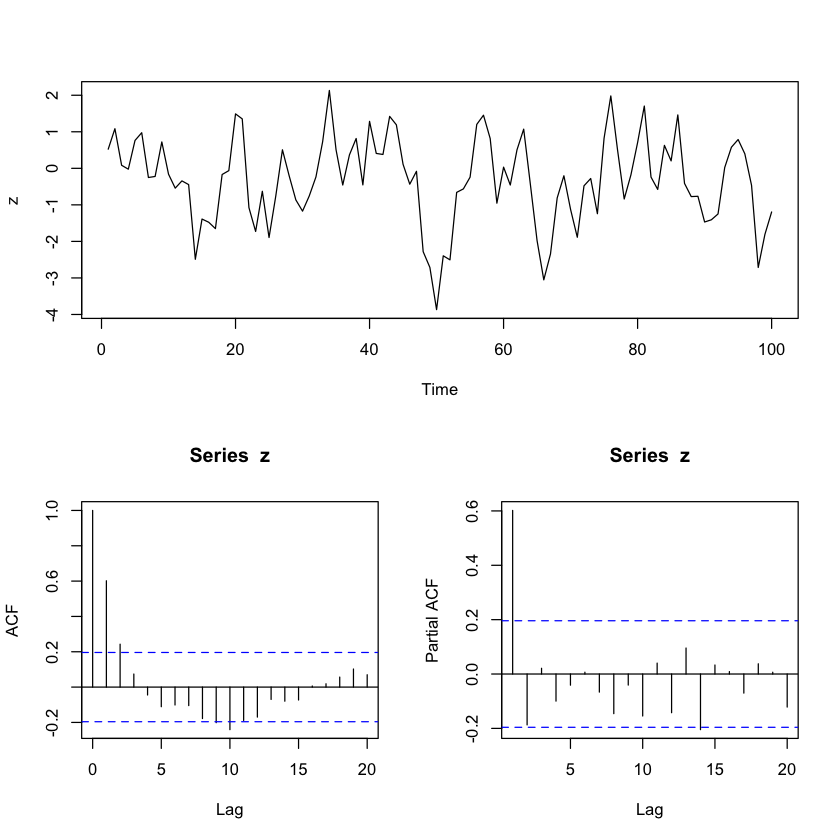

In [74]:
layout.matrix <- matrix(c(1, 2, 1, 3), nrow = 2, ncol = 2)
layout(mat = layout.matrix)
plot.ts(z)
acf(z)
pacf(z)

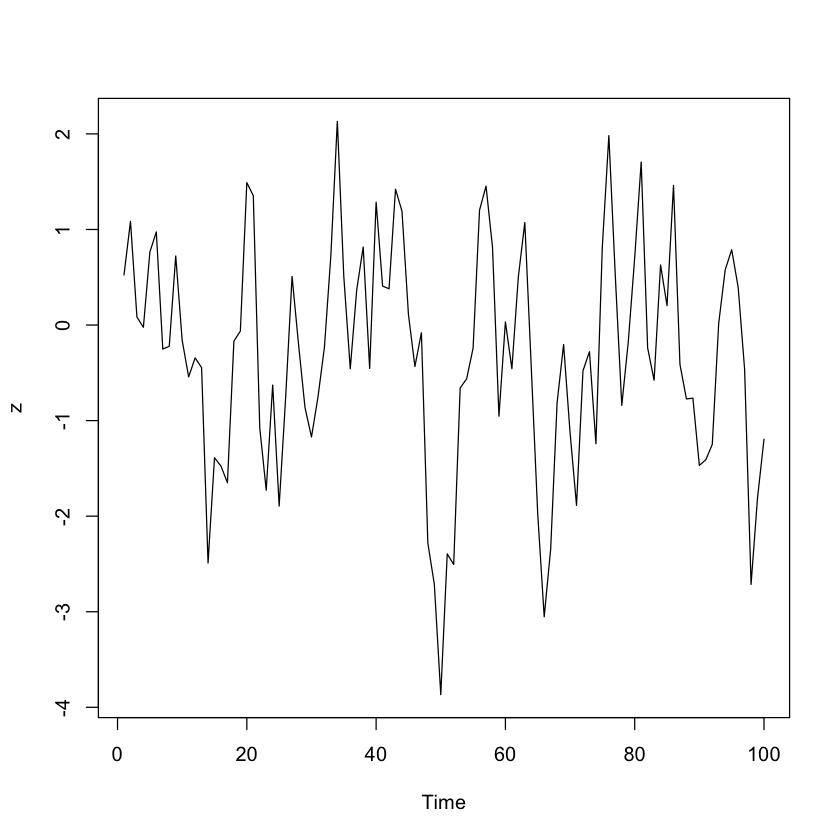

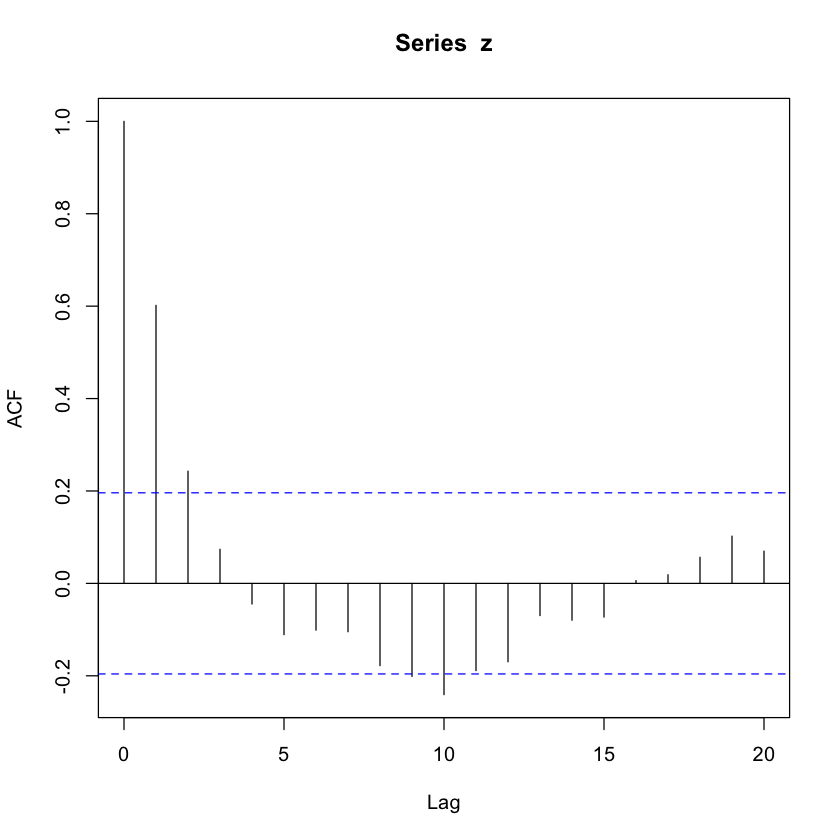

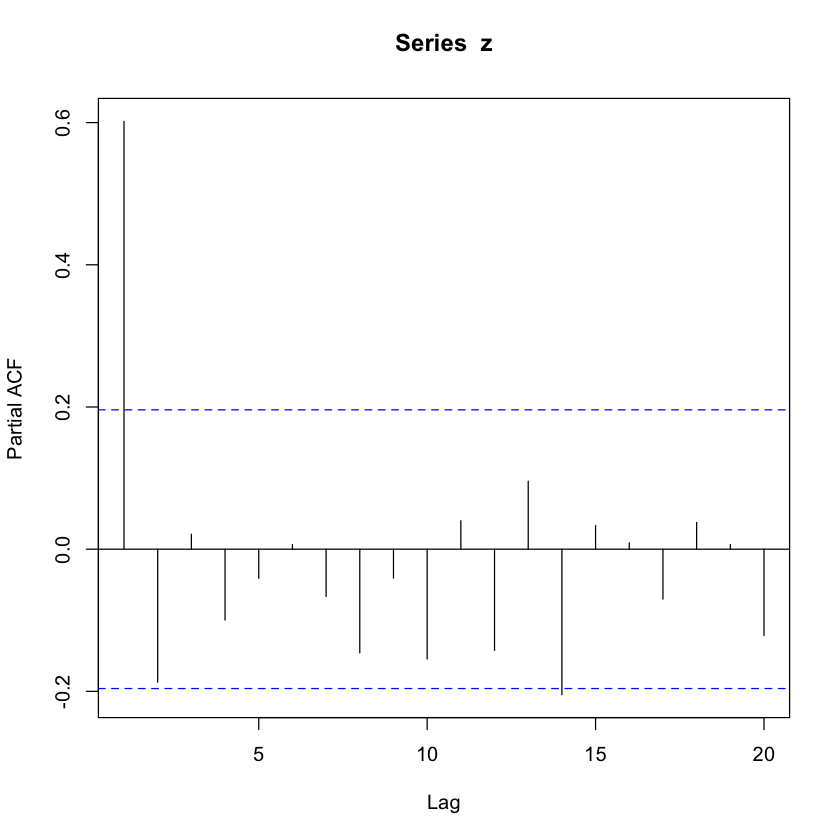

In [75]:
plot.ts(z)
acf(z)
pacf(z)

`-` 예를들어 AR(2)면

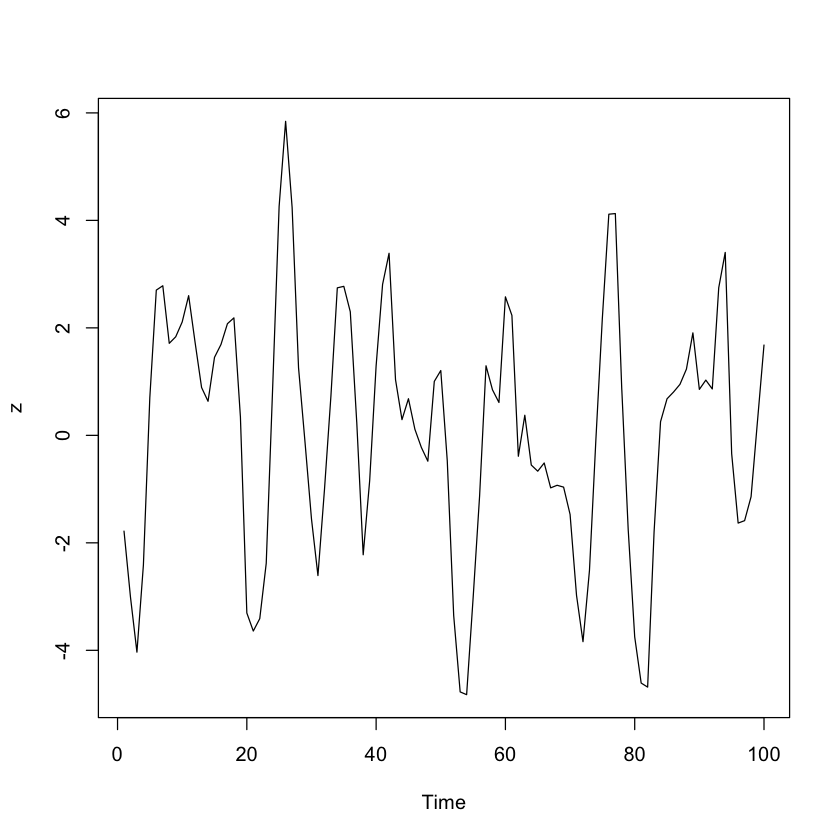

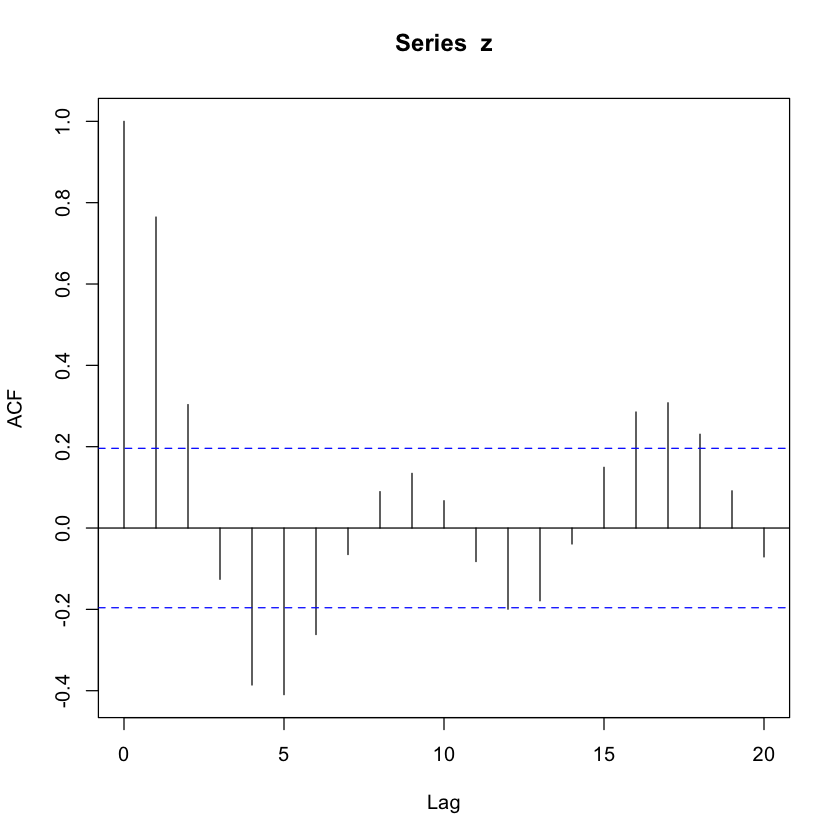

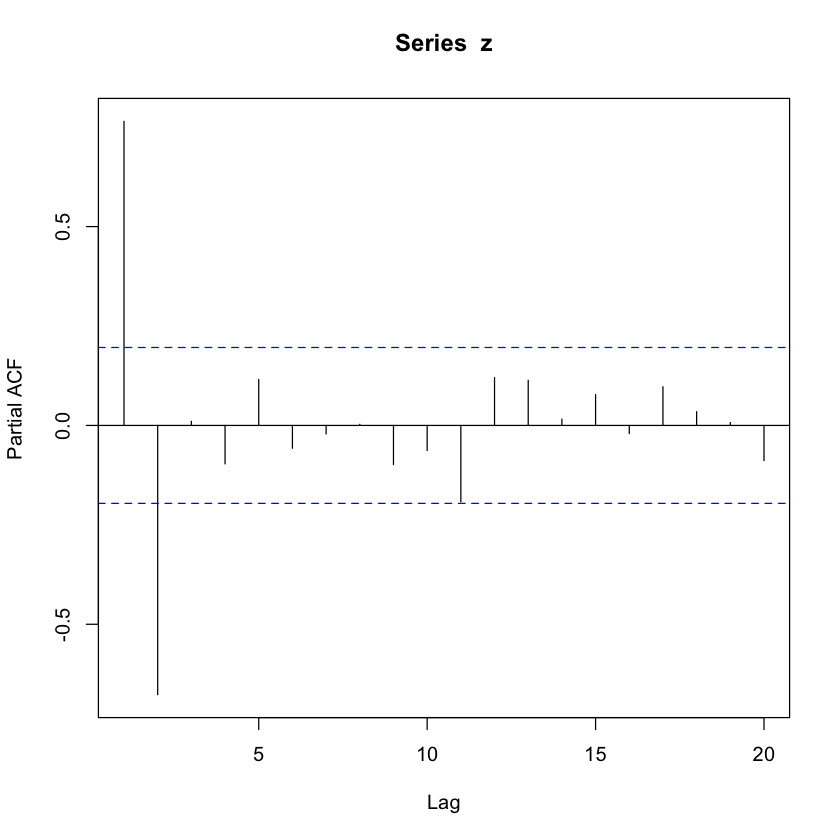

In [76]:
z <- sim_ar(100, 0, phi = c(1.3, -0.7), 1)

plot.ts(z)
acf(z)
pacf(z)

- 해석 : pacf보면 2개만 유의한 것을 볼 수 있음.

### 패키지 모델 사용한 AR(1)

- 저렇게 손으로 코드 안짜도 되는 것이 이미 패키지 모델 만들어져 있음.

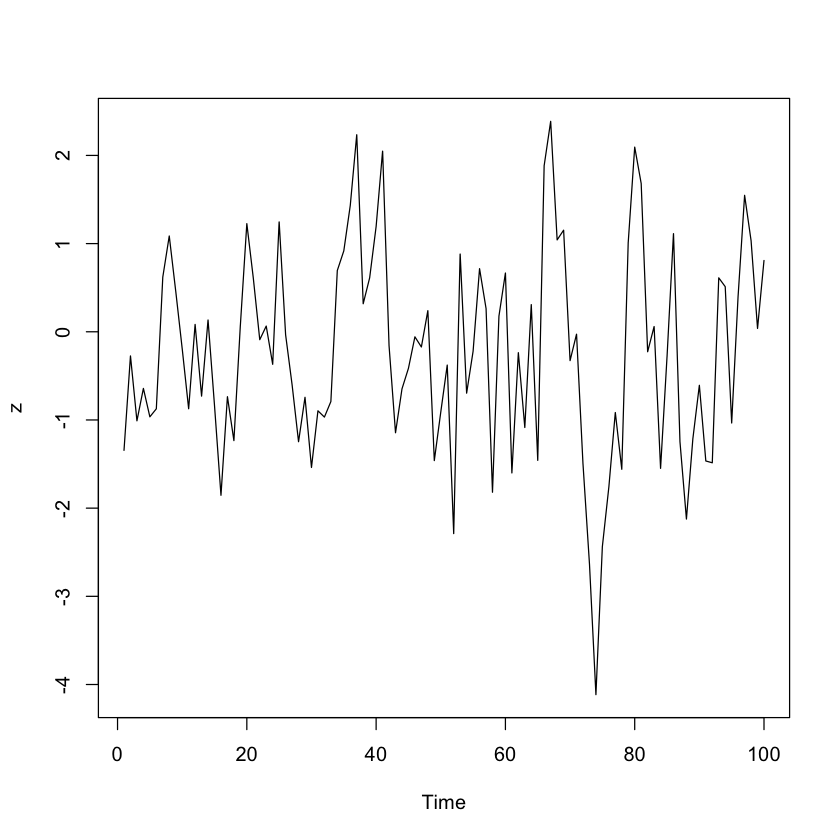

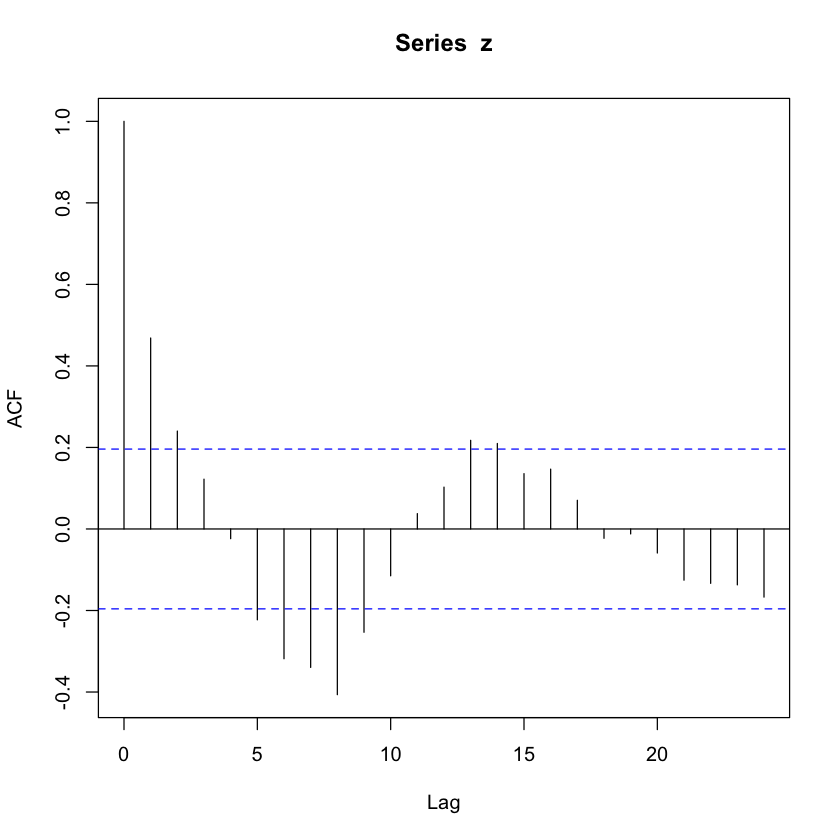

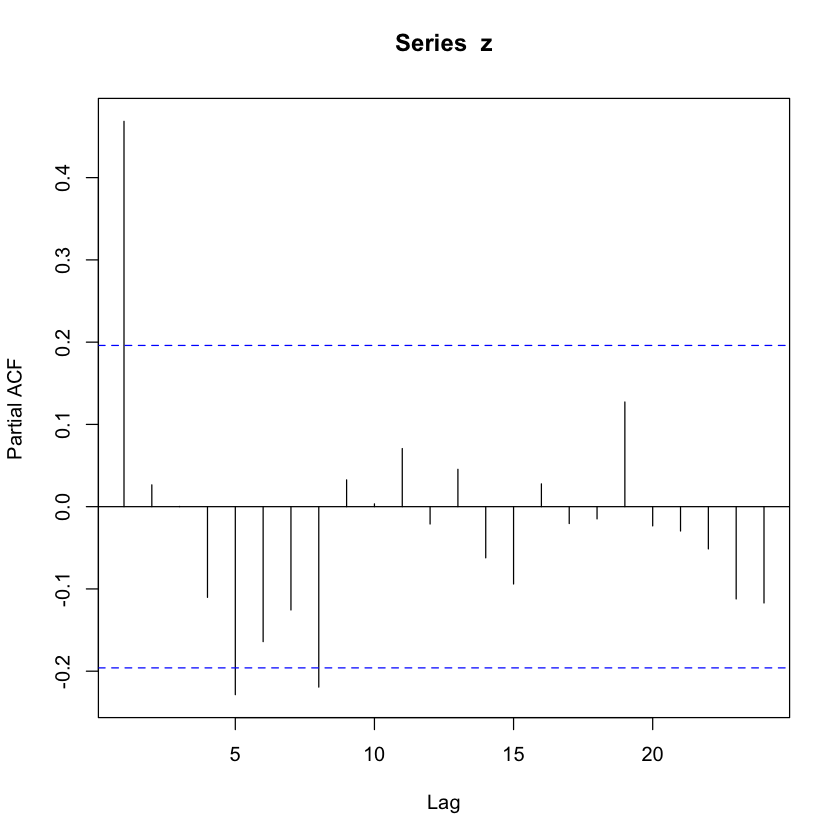

In [77]:
z <- arima.sim(n = 100, # 이름이 .sim인 이유는 simulation이라서
               list(order = c(1, 0, 0), ar = 0.5), # order = c(p, d, q)인데 ARMA는 d가 0인거임, 여기는 AR이니 d, q를 0으로
               # 뒤에 ar = phi의미
               rand.gen = rnorm)

plot.ts(z)
acf(z, lag.max = 24)
pacf(z, lag.max = 24)

### 패키지 모델 사용한 AR(2)

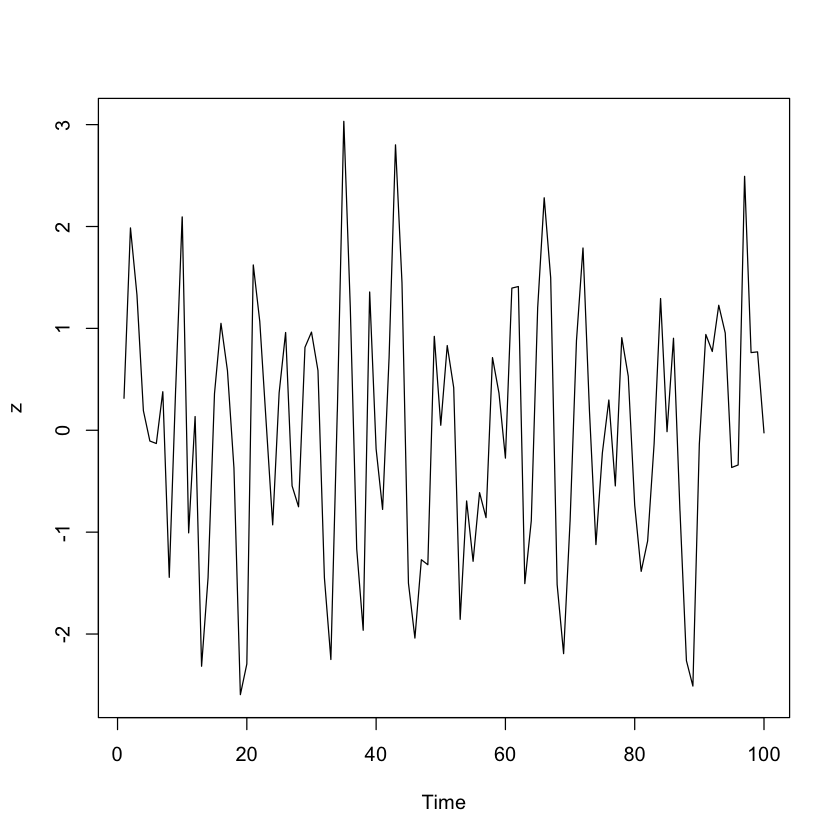

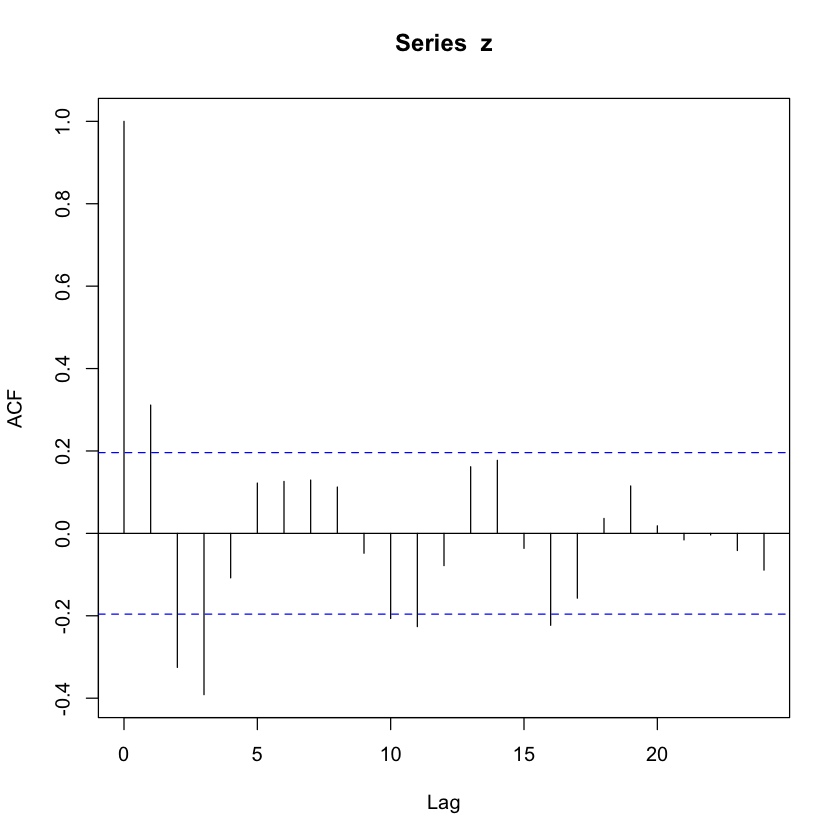

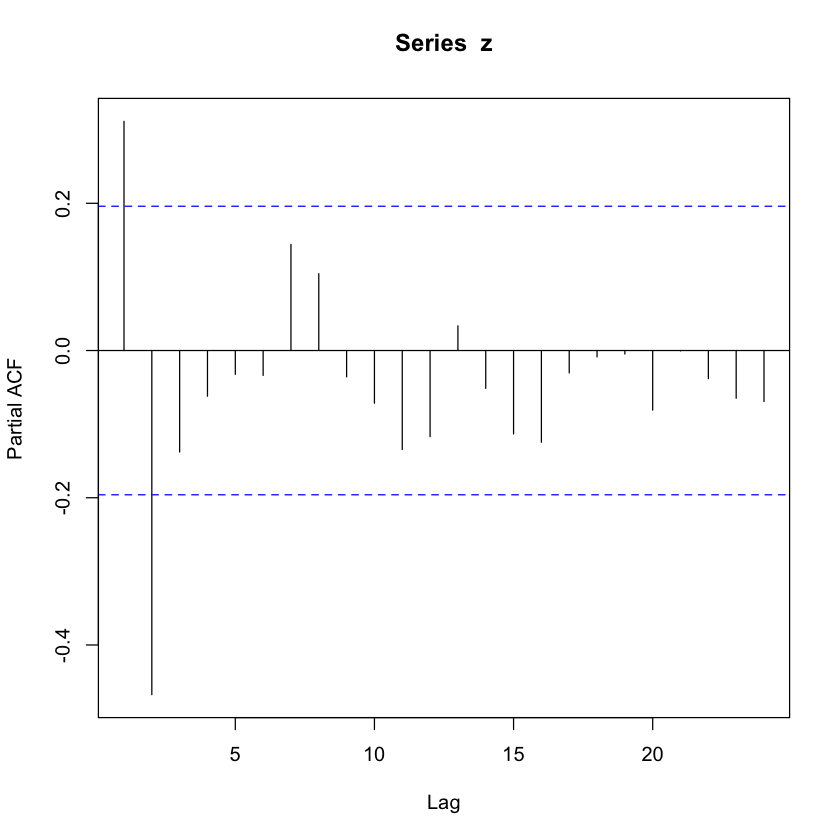

In [78]:
z <- arima.sim(n = 100,
               list(order = c(2, 0, 0), ar = c(0.5, -0.4)), # sd옵션 추가하면 분산도 변경가능 궁금한 것은 help가서 보기
               rand.gen = rnorm)

plot.ts(z)
acf(z, lag.max = 24)
pacf(z, lag.max = 24)

- ggplot으로 그리기

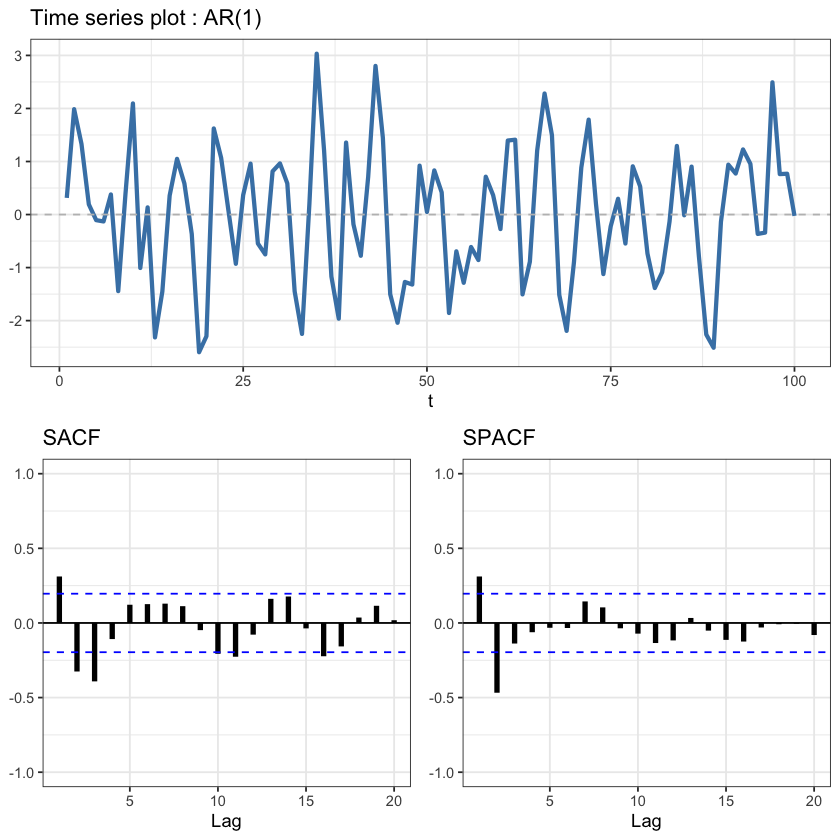

In [79]:
p1 <- ggplot(data.frame(t = 1:length(z), z = as.numeric(z)), aes(t, z)) +
geom_line(col = 'steelblue', lwd = 1.2) +
geom_hline(yintercept = 0, lty = 2, col = 'grey') +
ggtitle("Time series plot : AR(1)") +
theme_bw() +
theme(axis.title.y = element_blank())

p2 <- ggAcf(z, lwd = 1.5) +
theme_bw() + ylim(-1, 1) +
ggtitle("SACF") +
theme(axis.title.y = element_blank())

p3 <- ggPacf(z, lwd = 1.5) +
theme_bw() + ylim(-1, 1) +
ggtitle("SPACF") +
theme(axis.title.y = element_blank())

grid.arrange(p1, p2, p3, nrow = 2,
             layout_matrix = rbind(c(1, 1),
                                   c(2, 3)))

## MA

### function으로 만든 MA(1)

- 함수로 생성하기

$Z_t = \epsilon_t - \theta_1 * \epsilon_{t-1} + ... + \theta_q * \epsilon_{t-q}$

In [80]:
sim_ma <- function(n, mu, theta, sigma){
    q <- length(theta)
    ep <- rnorm(n + 100, 0, sigma)
    z <- ep
    
    for(k in (q+1) : (n + 100)){
        z[k] <- mu + ep[k] - sum(ep[(k-1):(k-q)]*theta)
        }
    return(z[-(1:100)])
    }

`-` 예를들어 MA(1)면

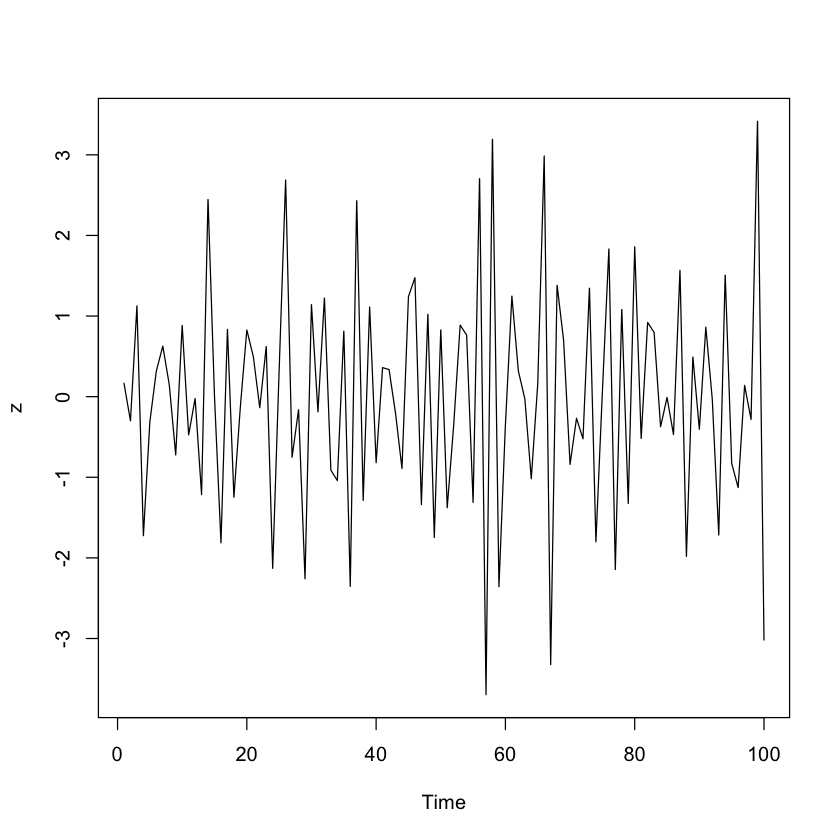

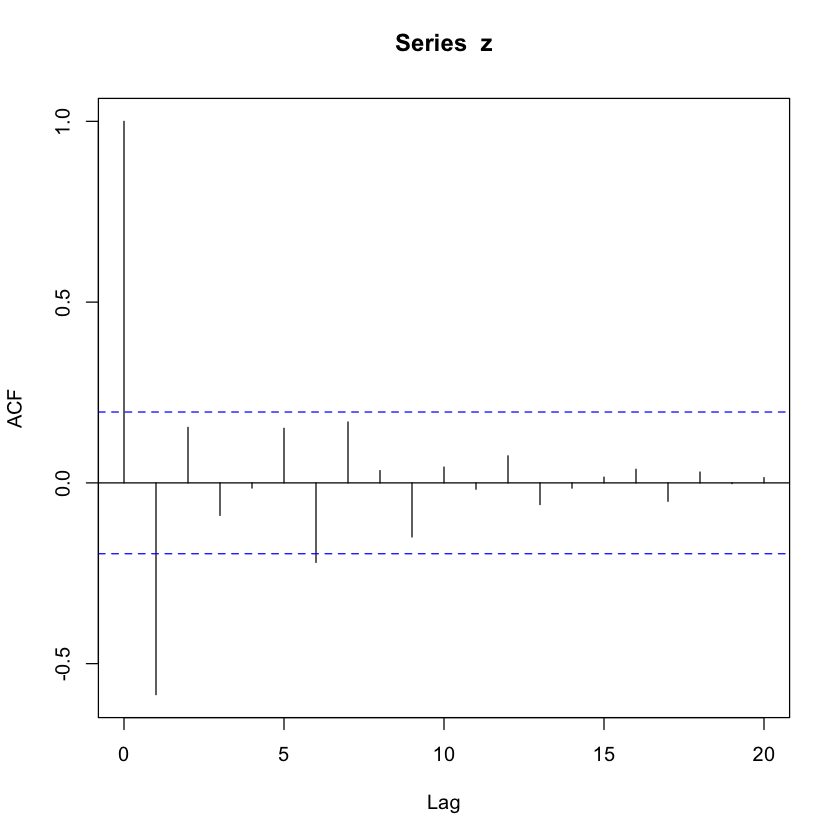

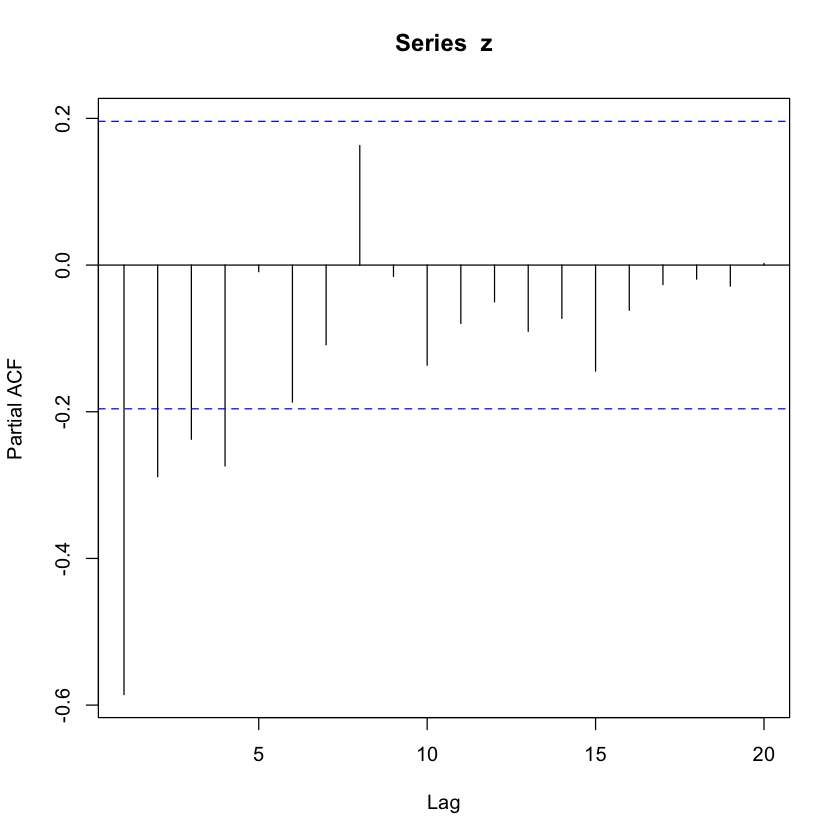

In [81]:
z <- sim_ma(100, 0, theta = 0.9, 1)

ts.plot(z)
acf(z)
pacf(z)

- 해석 : MA의 경우 acf보면 되는데 2번째 것까지 유의하게 나오니 맞다.

- 이 역시 패키지로 만들어져 있다.

### 패키지 모델 사용한 MA(1)

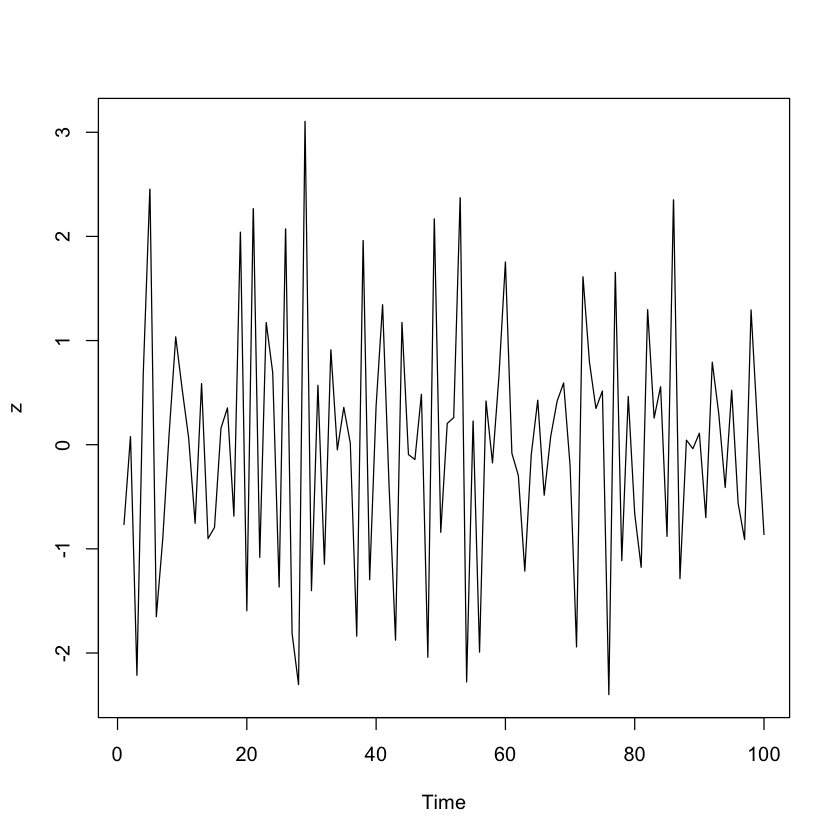

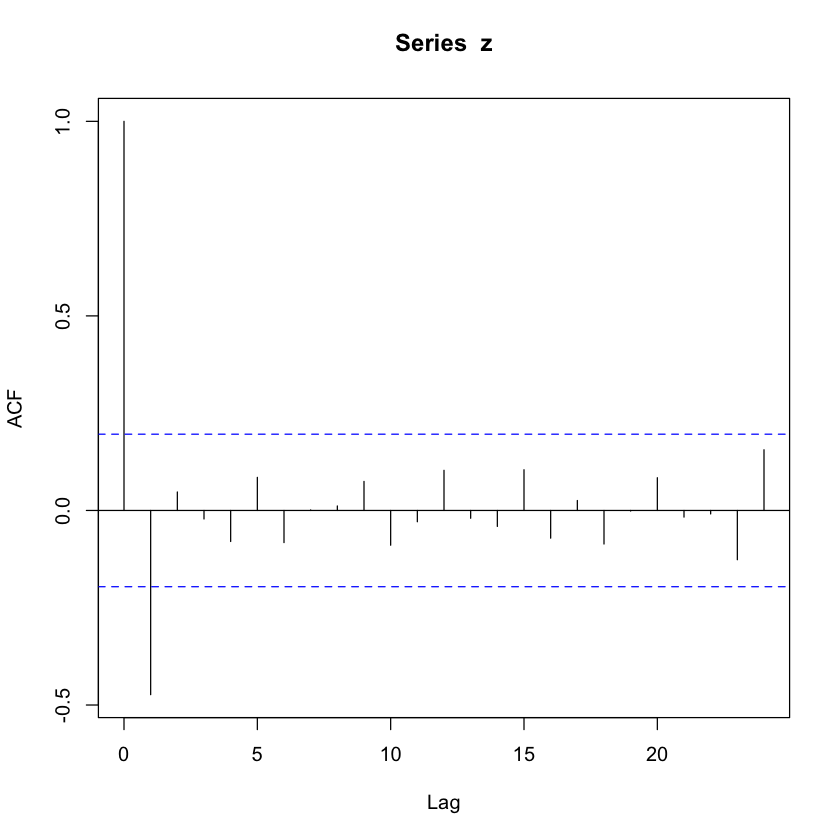

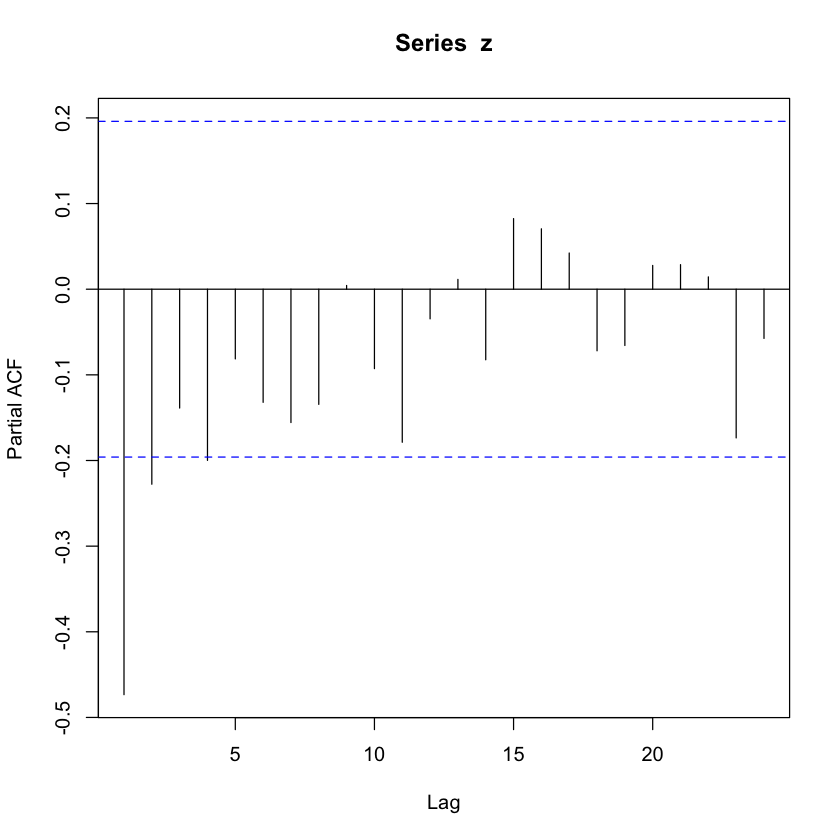

In [82]:
z <- arima.sim(n = 100,
               list(order = c(0,0,1), ma = -0.9), # 이거 help가서 패키지 짜여진 식을 보면 위에서 손으로 짠 식과 부호가 반대임 그래서 "-"붙임.
               rand.gen = rnorm)

ts.plot(z)
acf(z, lag.max = 24)
pacf(z, lag.max = 24)

### 패키지 모델 사용한 MA(2)

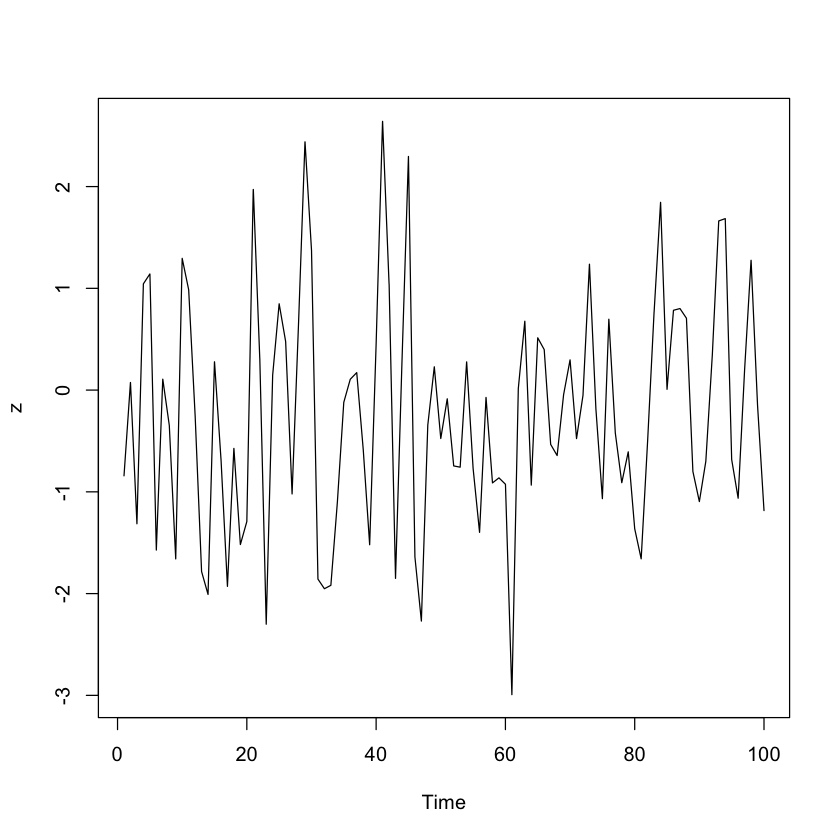

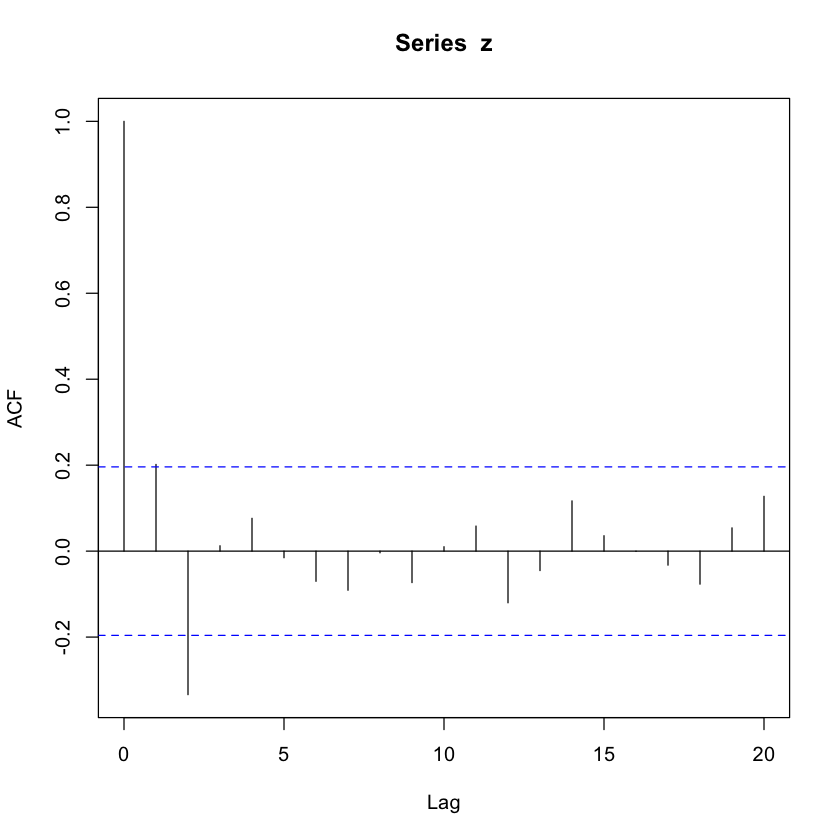

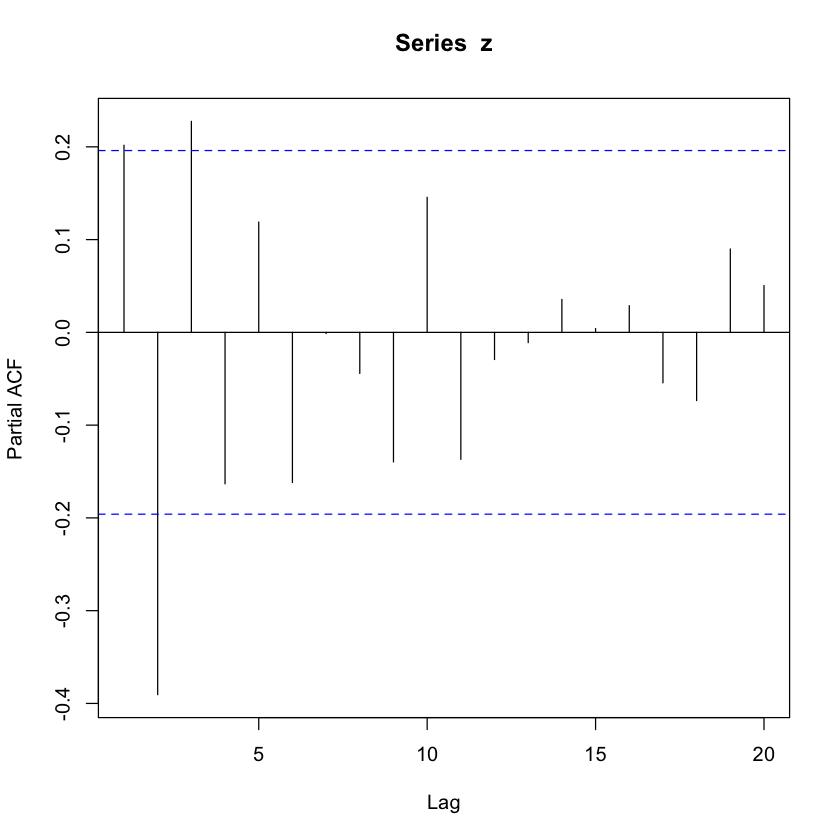

In [83]:
z <- arima.sim(n = 100,
               list(order = c(0,0,2), ma = c(0.5, -0.2)),
               rand.gen = rnorm)

ts.plot(z)
acf(z, lag.max = 20)
pacf(z, lag.max = 20)

## ARMA(1, 1)

- 역시 함수 짜서 해도 된다.<br>
여기서는 패키지 써서

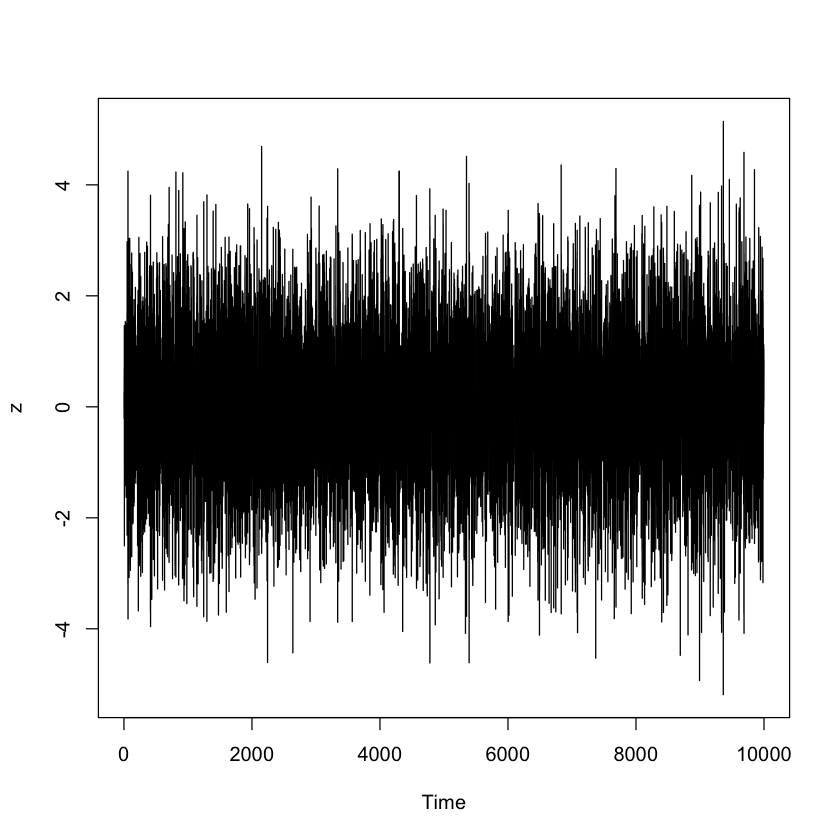

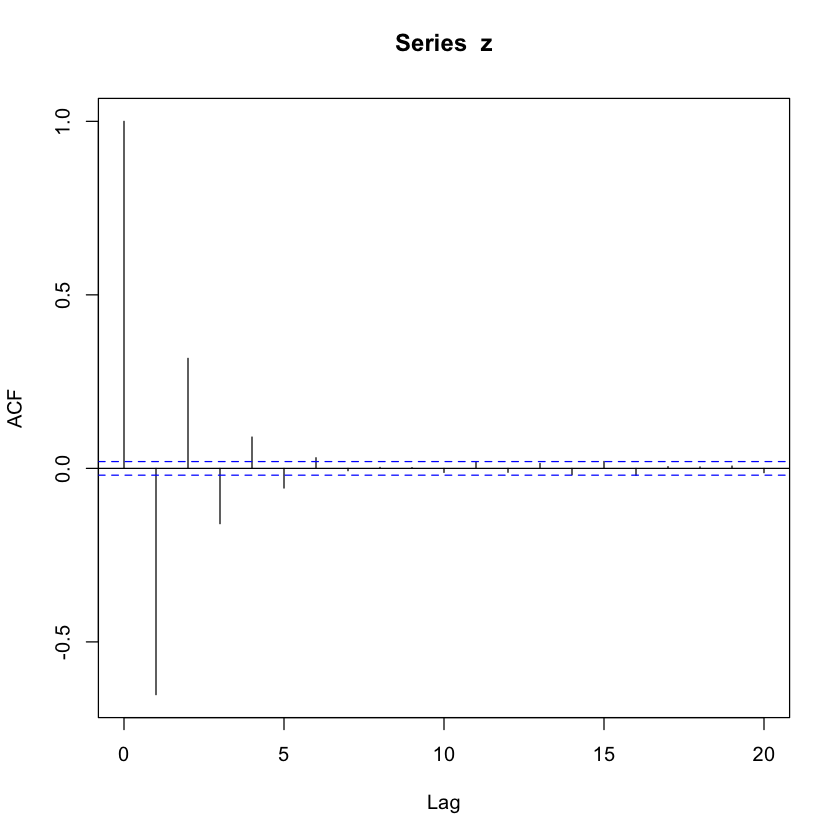

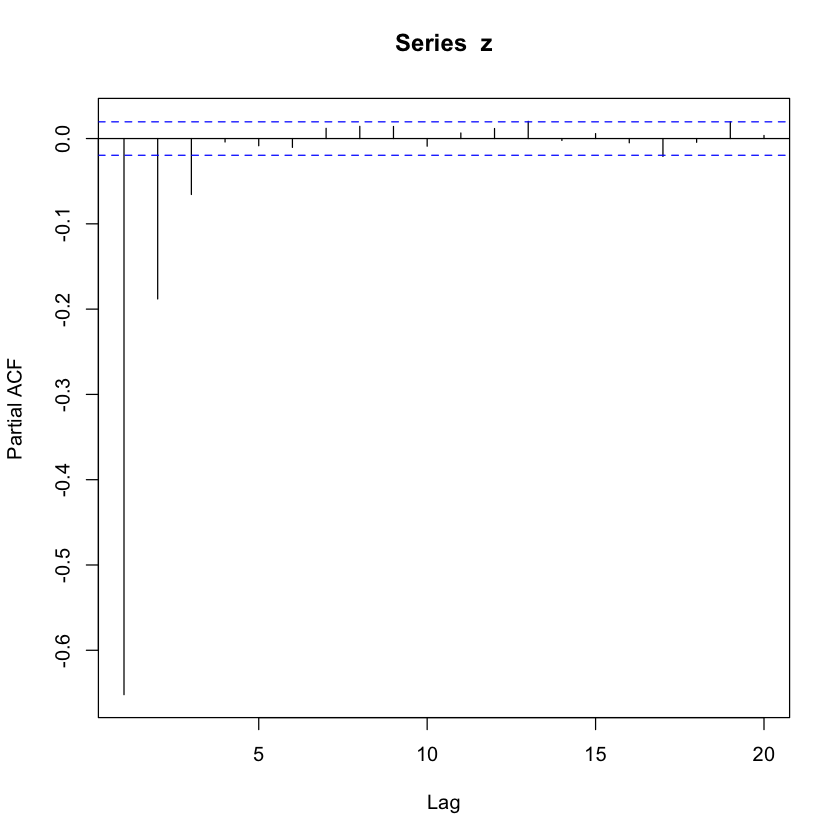

In [84]:
z <- arima.sim(n = 10000, list(order = c(1, 0, 1),
                               ar = -0.5, ma = -0.3),
               rand.gen = rnorm)

plot.ts(z)
acf(z, lag.max = 20)
pacf(z, lag.max = 20)

- 해석 : acf, pacf 둘 다 감소하고 있다. -> "ARMA모형이네"<br>
참고로 위의 그림에서 acf로만 보면 MA(5)정도를 사용해야할 것 같고,<br>
pacf로만 보면 AR(4)정도 사용해야 할 것 같은데<br>
종합해서 ARMA(1, 1)를 사용해버리면 추정해야될 것이 5개, 4개에서 2개로 줄어들기에 더 이득이라 볼 수 있다.